# Solara

In [ ]:
#| default_exp solara

In [ ]:
#| exporti
import sqlite3
import solara
import pandas as pd
import matplotlib.pyplot as plt

## Sqlite connection

In [ ]:
con = sqlite3.connect(':memory:')
cur = con.cursor()

In [ ]:
%cd {"../professor_cheat_sheet"}

/home/italo/open/ufrn-cheat-sheet/professor_cheat_sheet


In [ ]:
#| export
df = pd.read_csv('turma_matricula_docente_filtrados.csv')

In [ ]:
#| export
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [ ]:
#| export
columns = ", ".join(col for col in df.columns)

In [ ]:
#| export
question_marks = ", ".join("?" for _ in df.columns)

In [ ]:
#| export
to_db = [tuple(row.values) for i, row in df.iterrows()]

In [ ]:
#| export
del df

In [ ]:
#| export
con = sqlite3.connect(":memory:")
cur = con.cursor()
cur.execute(f"CREATE TABLE data ({columns});") # use your column names here

to_db = [tuple(row.values) for i, row in df.iterrows()]

cur.executemany(f"INSERT INTO data ({columns}) VALUES ({question_marks});", to_db)
con.commit()

## Solara App

In [ ]:
#| export
cur.execute('SELECT DISTINCT unidade_responsavel FROM data ORDER BY unidade_responsavel')
unidades = [row[0] for row in cur.fetchall()]

In [ ]:
#| export
unidade = solara.reactive(None)
componente = solara.reactive(None)
docente = solara.reactive(None)

In [ ]:
#| export
@solara.component
def SelectUnidade():
    solara.Select(label="Unidade", value=unidade, values=unidades)

In [ ]:
#| export
@solara.component
def SelectComponente():
    cur.execute(
        'SELECT DISTINCT nome_componente FROM data '
        'WHERE unidade_responsavel = ? ORDER BY nome_componente', 
        (unidade.value,)
    )
    values = [row[0] for row in cur.fetchall()]
    solara.Select(label="Componente", value=componente, values=values)

In [ ]:
#| export
@solara.component
def SelectDocente():
    cur.execute(
        'SELECT DISTINCT nome_docente FROM data '
        'WHERE unidade_responsavel = ? AND nome_componente = ? '
        'ORDER BY nome_docente', 
        (unidade.value, componente.value)
    )
    values = [row[0] for row in cur.fetchall()]
    solara.Select(label="Docente", value=docente, values=values)

In [ ]:
#| export
def PieChart():
    cur.execute(
        'SELECT descricao FROM data '
        'WHERE unidade_responsavel = ? AND nome_componente = ? AND nome_docente = ? '
        'ORDER BY descricao', 
        (unidade.value, componente.value, docente.value)
    )

    descriptions = [row[0] for row in cur.fetchall()]

    data = pd.DataFrame(descriptions, columns=['descricao'])
    contagem_descricao = data['descricao'].value_counts()
    porcentagens = (contagem_descricao / contagem_descricao.sum()) * 100

    fig, ax = plt.subplots(figsize=(10, 6))
    wedges, texts, autotexts = ax.pie(
        porcentagens, 
        labels=porcentagens.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4)
    )

    for text, autotext in zip(texts, autotexts):
        text.set(size=10)
        autotext.set(size=10)

    legend_labels = [f"{label}: {value}" for label, value in zip(contagem_descricao.index, contagem_descricao.values)]
    ax.legend(
        wedges, 
        legend_labels, 
        title="Descrições", 
        loc="center left", 
        bbox_to_anchor=(1, 0, 0.5, 1)
    )
    solara.FigureMatplotlib(fig)

In [ ]:
#| export
@solara.component
def Page():
    SelectUnidade()
    SelectComponente()
    SelectDocente()
    PieChart()

Cannot show ipywidgets in text

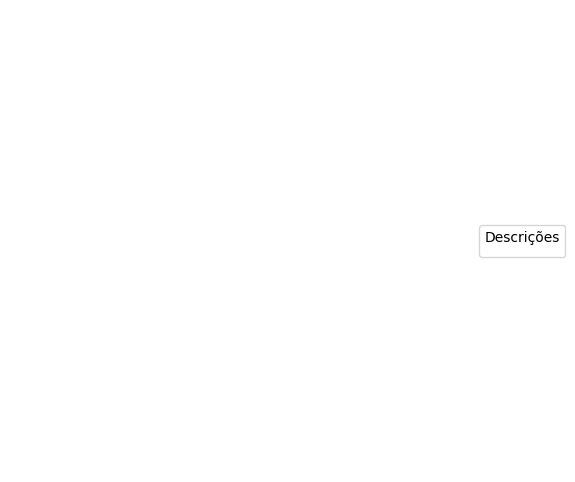

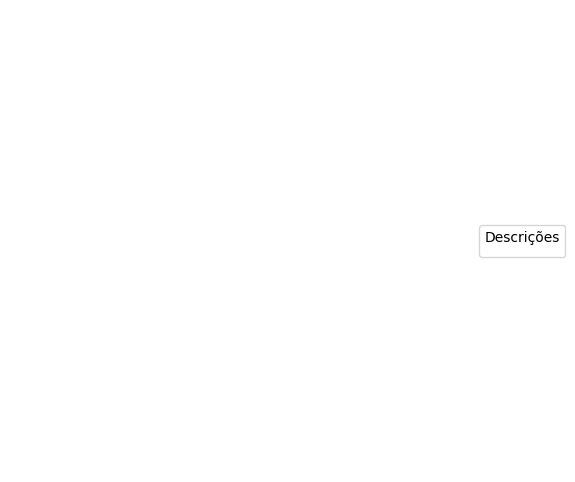

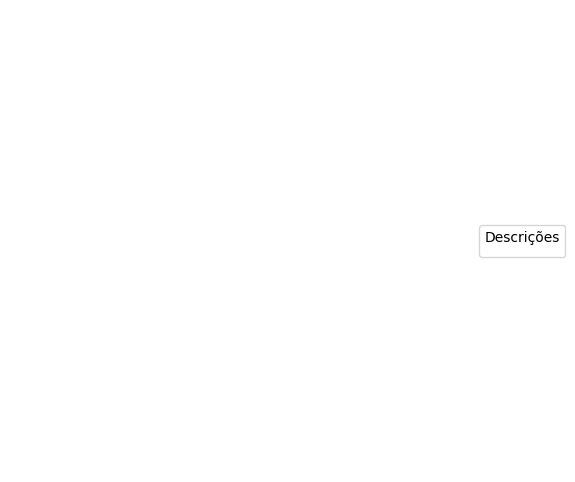

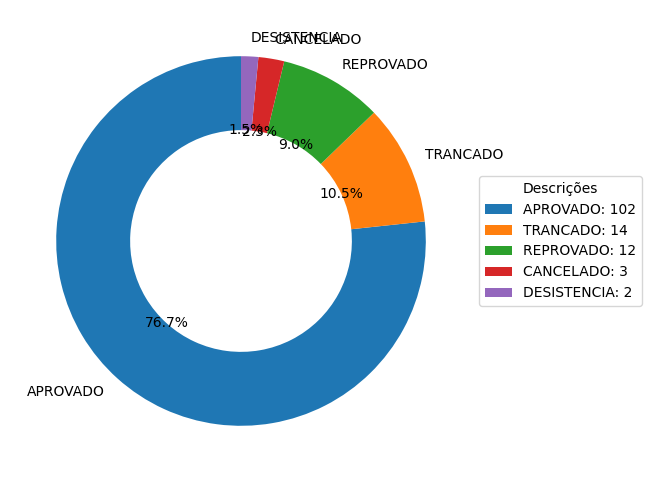

In [ ]:
#| export
Page()